In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import Activation, BatchNormalization
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img, array_to_img

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

PATH = 'dataset/exp-data'
# data variables
IMG_SIZE = 128
CHANNELS = 3
NOISE_DIM = 100

# training variables
EPOCHS = 300
BATCH_SIZE = 16

# hyperparameter tuning 
MOMENTUM = 0.8
EPSILON = 0.00005
LEARNING_RATE=0.0002
BETA1 = 0.5

# create numpy array (tensor) for the dataset
train_images = np.ndarray(shape=(6000, IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, img in enumerate(os.listdir(PATH)):
    if i >= 6000:
        break
    # using keras image preprocessing package convert the images into a matrix
    image = load_img(PATH + '/' + img)
    x = img_to_array(image)
    
    # add the matrices into the tensor
    train_images[i] = x

train_images.shape

Using TensorFlow backend.


(6000, 128, 128, 3)

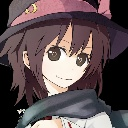

In [2]:
test = array_to_img(train_images[100])
test

In [3]:
train_images = train_images/127.5 - 1 # normalize data to -1 to 1
len(train_images[0])

128

In [4]:
def Generator():    
    model = Sequential()
    model.add(Dense(8*8*1024, input_dim=NOISE_DIM))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Reshape((8, 8, 1024)))

    # 8x8x1024 -> 16x16x512
    model.add(Conv2DTranspose(512, (5,5), strides=(2,2), padding="same"))
    model.add(BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON))
    model.add(LeakyReLU())
    
    # 16x16x512 -> 32x32x256
    model.add(Conv2DTranspose(256, (5,5), strides=(2,2), padding="same"))
    model.add(BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON))
    model.add(LeakyReLU())
    
    # 32x32x256-> 64x64x128
    model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding="same"))
    model.add(BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON))
    model.add(LeakyReLU())
    
    # 64x64x128 -> 128x128x64
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding="same"))
    model.add(BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON))
    model.add(LeakyReLU())
    
    # 128x128x64 -> 128x128x3
    model.add(Conv2DTranspose(3, (5,5), strides=(1,1), padding="same"))
    model.add(BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON))
    model.add(Activation('tanh'))
    
    model.summary()
    
    z = Input(shape=(NOISE_DIM,))
    generated_image = model(z)
    
    return Model(inputs=z, outputs=generated_image)

In [5]:
def Discriminator():
    model = Sequential()
    
    # 128*128*3 -> 64x64x64
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    # 64x64x64-> 32x32x128 
    model.add(Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    # 32x32x128 -> 16x16x256
    model.add(Conv2D(256, (5,5), strides=(2,2), padding="same"))
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    # 16x16x256 -> 16x16x512
    model.add(Conv2D(512, (5,5), strides=(1,1), padding="same"))
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    # 16x16x512 -> 8x8x1024
    model.add(Conv2D(1024, (5,5), strides=(2,2), padding="same"))
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    img = Input(shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
    pred = model(img)
    
    return Model(img, pred)

In [6]:
# define optimizer
adam = Adam(lr=LEARNING_RATE, beta_1=BETA1)

generator = Generator()
discriminator = Discriminator()

# compile the discriminator
discriminator.compile(loss='binary_crossentropy', 
              optimizer=adam,
             metrics=['accuracy'])

discriminator.trainable = False
# generator noise
z_input = Input(shape=(NOISE_DIM,))
fake_image = generator(z_input)
fake_pred = discriminator(fake_image)

# compile generator and discriminator
# training generator to fool discriminator
gan = Model(inputs=z_input, outputs=fake_pred)
gan.compile(loss='binary_crossentropy', optimizer=adam)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
batch_normalization_1 (Batch (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 65536)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
leak

In [7]:
store_image_dir = 'dcgan-improved-images'

try:
    os.makedirs(store_image_dir)
except FileExistsError:
    pass

def show_samples(epoch, sample_images, dim=(4,4), figsize=(8,8)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(sample_images):
        img = ((img+1.0)*127.5).astype('int')
        image = array_to_img(img)
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/epoch {}.png'.format(store_image_dir, epoch))
    plt.show()
    plt.close()

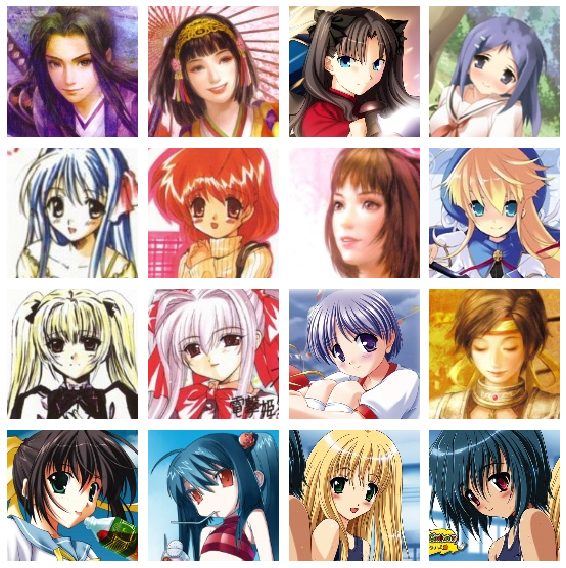

In [8]:
show_samples(0,train_images[16:32])

In [15]:
losses = []

def train(epochs, batch_size=64,step=1):
    # training of (6000,128,128,3)
    m = train_images.shape[0] # number of training examples
    batch_count = m/batch_size # number of minibatches
    print ('Epochs:', epochs)
    print ('Batch size:', batch_size)
    print ('Batches per epoch:', batch_count)
        
    for e in range(step, epochs+1):

        # minibatches without the end case
        for _ in tqdm(np.arange(batch_count)):
            # random m samples from gaussian distribution
            z_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_DIM))
            # getting m training samples
            x_batch = train_images[np.random.randint(0, train_images.shape[0], size=BATCH_SIZE)]

            # generating m images from random normal distribution sampling
            generated_images = generator.predict(z_batch)
            
            # creating labels for real and fake data for training
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            # one-sided label smoothing
            # https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
            real_labels[:] = 0.9

            # train discriminator
            discriminator.trainable = True
            dloss_real = discriminator.train_on_batch(x_batch, real_labels)
            dloss_fake = discriminator.train_on_batch(generated_images, fake_labels)
            dloss = 0.5 * np.add(dloss_real, dloss_fake)

            # train generator
            discriminator.trainable = False
            gloss = gan.train_on_batch(z_batch, real_labels)

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e, dloss[0], 100*dloss[1], gloss))

        if e == step or e % 5 == 0:
            z_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_DIM))
            generated_images = generator.predict(z_batch)
            show_samples(e, generated_images)

        if e % 10 == 0 and e is not step:
            print('Model saved for epoch {}'.format(e))
            saver.save(sess,'model/dcgan-improved-model',global_step=e)

        losses.append([dloss,gloss])

In [16]:
with tf.Session() as sess:
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    print(sess)

Epochs: 300
Batch size: 16
Batches per epoch: 375.0


100%|██████████| 375/375 [04:07<00:00,  1.50it/s]


1 [D loss: 0.490396, acc.: 46.88%] [G loss: 2.495820]


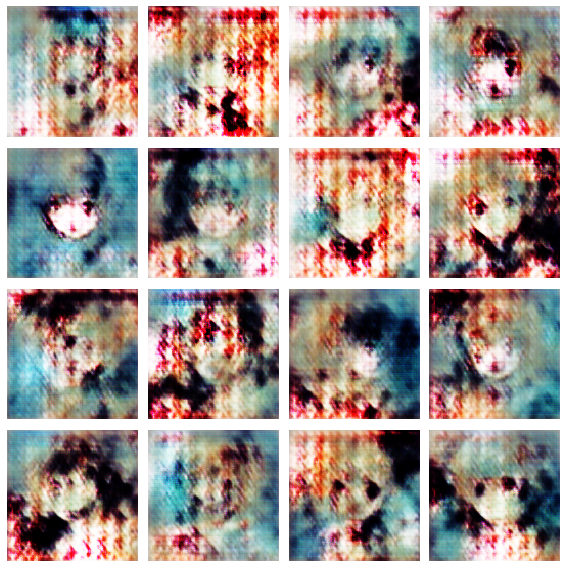

 12%|█▏        | 45/375 [00:30<03:41,  1.49it/s]

KeyboardInterrupt: 

In [17]:
train(EPOCHS, batch_size=BATCH_SIZE)

In [ ]:
import csv
with open('losses/dcgan-improved-losses.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(losses)